In [1]:
from torch.utils.data import DataLoader, WeightedRandomSampler
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch.utils.data import DataLoader
import wandb
from models.vgg19_model import get_vgg19_model
from models.vit_model import get_vit_model
from models.alexnet_model import get_alexnet_model
from models.gideon_alex_net import get_gideon_alexnet_model
from models.resnet_model import get_resnet_model, get_timm_model
from models.resnet_model import get_timm_model
from models.dino_model import get_dinov2_model
from torchvision import transforms
from preprocessing.clahe import CLAHETransform
from utils.logger import init_wandb
from collections import Counter
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from losses.label_smoothing import LabelSmoothingCrossEntropy
from losses.confidence_weighted_loss import ConfidenceWeightedCrossEntropy
from losses.combined_loss import CombinedLabelSmoothingConfidenceWeightedLoss

from utils.hard_sampling import get_low_confidence_samples
from utils.saver import save_test_outputs
import random
import numpy as np
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from sklearn.model_selection import KFold
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from sklearn.model_selection import KFold
from dataset_handler.dataset import ImageDataset
from preprocessing.clahe import CLAHETransform
import tqdm

/workspace/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def ensemble_test_predictions(models, test_dataset):
    loader = DataLoader(test_dataset, batch_size=32)
    all_probs = []
    true_labels = []
    filenames = []

    for images, labels, paths in loader:
        images = images.to("cuda")
        batch_probs = []

        for model in models:
            model.eval()
            with torch.no_grad():
                logits = model(images)
                probs = F.softmax(logits, dim=1)
                batch_probs.append(probs.cpu())

        avg_probs = torch.stack(batch_probs).mean(dim=0)
        all_probs.append(avg_probs)
        true_labels.extend(labels.numpy())
        filenames.extend(paths)

    all_probs = torch.cat(all_probs).numpy()
    predicted_labels = np.argmax(all_probs, axis=1)
    return filenames, true_labels, predicted_labels, all_probs

In [3]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import os
import numpy as np

# Your ensemble_test_predictions function goes here (already provided)

# Example model class — replace with your actual one
from torchvision.models import resnet50
from torch.nn import Linear

def create_model(num_classes):
    model = resnet50(pretrained=False)
    model.fc = Linear(model.fc.in_features, num_classes)
    return model

def load_models_from_folder(folder_path, num_classes, device="cuda"):
    model_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".pth")]
    models = []

    for path in model_paths:
        model_class_name = os.path.split(path)[-1].split("_")[0]
        if model_class_name=="ResNet50":
            model = get_resnet_model(path)
        else:
            model = get_timm_model(path,model_class_name)

        # model = create_model(num_classes)
        model.load_state_dict(torch.load(path, map_location=device))
        model.to(device)
        models.append(model)

    return models


In [4]:
from argparse import Namespace


size = (512, 512) 
args = Namespace(LEARNING_RATE=7, BATCH_SIZE=32,NUM_CLASSES=3, NUM_EPOCHS=20, USE_CLAHE=False, MODEL_NAME='ResNet50', USE_OSTEOPENIA=True, USE_TEST_DATA_DIR=True, USE_SCHEDULER=True, TRAIN_WEIGHTED_RANDOM_SAMPLER=True, NUM_WORKERS=1, DATA_DIR='/workspace/osteoporosis_project/data/train_data', TEST_DATA_DIR='/workspace/osteoporosis_project/data/test_data', USE_LABEL_SMOOTHING=True, USE_HARD_SAMPLING=False, USE_CONFIDENCE_WEIGHTED_LOSS=False, CONFIDENCE_PENALTY_WEIGHT=2.0, CONFIDENCE_THRESHOLD=0.85, LABEL_SMOOTHING_EPSILON=0.1, USE_TRANSFORM_AUGMENTATION_IN_TRAINING=True, FINE_TUNE_LR_MULTIPLIER=1.0, DROPOUT=0.5, RESNET_LAYERS_TO_TRAIN=['fc', 'layer2', 'layer3', 'layer4'])
init_wandb(project_name="models_for_ensemble", args=args)
prepare_to_network_transforms = [
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]


augmentation_transform = [
    transforms.RandomResizedCrop(224),
    transforms.RandomRotation(degrees=10),  # Small random rotation
    transforms.RandomHorizontalFlip(p=0.5),  # 50% chance to flip
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Small shifts
    transforms.ColorJitter(brightness=0.2, 
                        contrast=0.2, 
                        saturation=0.2, 
                        hue=0.1),  # Adjust contrast
]

all_transformation = []
train_transformations = []
train_transformations += augmentation_transform

all_transformation += prepare_to_network_transforms
train_transformations += all_transformation
eval_transform = transforms.Compose(all_transformation)

train_transform = transforms.Compose(train_transformations)



test_dataset = ImageDataset("data/test_data")
test_dataset.transform = eval_transform


wandb: Currently logged in as: eladlaks (eladlaks-herzlia-reichman-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Wandb configuration:
DATA_DIR: /workspace/osteoporosis_project/data/train_data
TEST_DATA_DIR: /workspace/osteoporosis_project/data/test_data
DUPLICATE_THRESHOLD: 0.99
YOLO_WEIGHTS_PATH: /workspace/osteoporosis_project/pretrained/yolo_weights.pt
DEVICE: cuda
BATCH_SIZE: 32
NUM_EPOCHS: 20
LEARNING_RATE: 7
ALEX_FREEZE_FEATURES: True
USE_TRANSFORM_AUGMENTATION_IN_TRAINING: True
USE_CLAHE: False
MODEL_NAME: ResNet50
USE_OSTEOPENIA: True
SKIP_DUP_DATA: False
TRAIN_WEIGHTED_RANDOM_SAMPLER: True
NUM_WORKERS: 1
USE_TEST_DATA_DIR: True
USE_SCHEDULER: True
USE_LABEL_SMOOTHING: True
USE_CONFIDENCE_WEIGHTED_LOSS: False
USE_HARD_SAMPLING: False
CONFIDENCE_THRESHOLD: 0.85
CONFIDENCE_PENALTY_WEIGHT: 2.0
LABEL_SMOOTHING_EPSILON: 0.1
RESNET_LAYERS_TO_TRAIN: ['fc', 'layer2', 'layer3', 'layer4']
DROPOUT: 0.5
USE_METABOLIC_FOR_TEST: False
USE_K_FOLD: False
K_FOLDS: 5
NUM_CLASSES: 3
FINE_TUNE_LR_MULTIPLIER: 1.0
Run name: lr_7_bs_32_9vqoo8


In [11]:

num_classes = 3  # Or whatever is relevant

# Load models
folder_path = r"saved_models/ensembel_models"
models = load_models_from_folder(folder_path, num_classes)

# Get ensemble predictions
filenames, true_labels, predicted_labels, all_probs = ensemble_test_predictions(models, test_dataset)


/workspace/osteoporosis_project/models/resnet_model.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(
/tmp/ipykernel_160097/253166718.py:30: Fut

In [12]:
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score, f1_score,
    roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [16]:
def evaluate_predictions(true_labels, predicted_labels, all_probs, class_names):
    # Accuracy
    acc = accuracy_score(true_labels, predicted_labels)
    
    # F1 Score (macro for multi-class)
    f1 = f1_score(true_labels, predicted_labels, average='macro')
    
    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    
    # AUC (One-vs-Rest strategy)
    try:
        auc = roc_auc_score(true_labels, all_probs, multi_class='ovr')
    except ValueError:
        auc = None  # Sometimes fails if only one class in y_true

    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score (macro): {f1:.4f}")
    if auc is not None:
        print(f"AUC (OvR): {auc:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(true_labels, predicted_labels, target_names=class_names))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()
    return auc,f1,acc,cm


In [14]:
class_names = ["normal", "osteopenia", "osteoporosis"]


Accuracy: 0.7257
F1 Score (macro): 0.7061
AUC (OvR): 0.8693

Classification Report:
              precision    recall  f1-score   support

      normal       0.76      0.67      0.71        39
  osteopenia       0.81      0.85      0.83        46
osteoporosis       0.55      0.61      0.58        28

    accuracy                           0.73       113
   macro avg       0.71      0.71      0.71       113
weighted avg       0.73      0.73      0.73       113



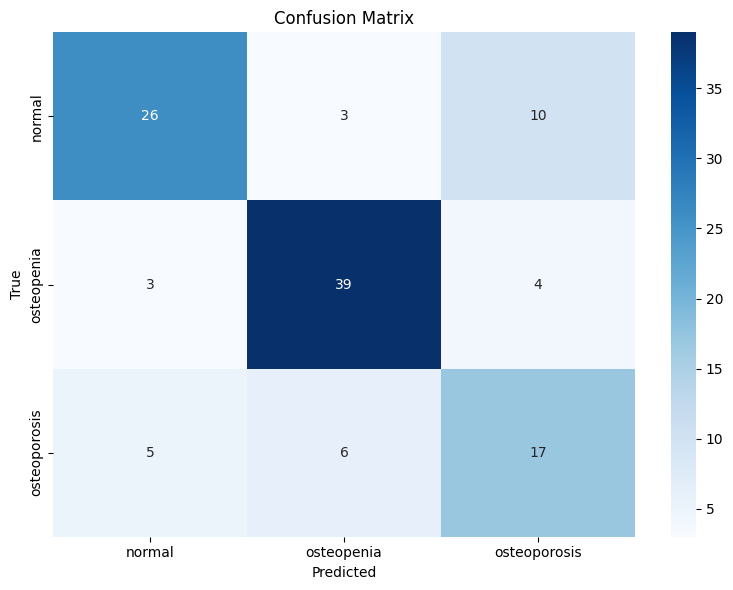

In [18]:
auc,f1,acc,cm = evaluate_predictions(true_labels, predicted_labels, all_probs, class_names)


In [19]:
wandb.log(
        {
            f"test_acc": acc,
            f"test_f1": f1,
            f"test_auc": auc if auc is not None else 0.0,
        }
    )

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix - enseble")
wandb.log({f"enseble_confusion_matrix": wandb.Image(plt)})
plt.close()

# # Classification Report + Per-Class Metrics
# report = classification_report(
#     all_labels_np, all_preds_np, output_dict=True, zero_division=0
# )
# wandb.log(
#     {f"{model_name}_classification_report": report}
# )  # Log per-class metrics (optional)
# for label, metrics in report.items():
#     if isinstance(metrics, dict):
#         for metric_name, value in metrics.items():
#             wandb.log({f"{model_name}_{label}_{metric_name}": value})
